# Google Speech Commands Dataset Generator 

1ms hop (25ms frames)
issues with generating all training/testing/validation data
(estimated 100gb system memory needed)

currently generating training/testing/validation data separately 

In [1]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import re
from tqdm import trange
import copy
import tarfile
import soundfile as sf

In [2]:
# get a directory to download and encode dataset files

directory = os.path.expanduser("~/data")

In [3]:
os.chdir(directory)

try:
    os.mkdir("rawSC")
except:
    pass

os.chdir("rawSC")

In [4]:
if not os.path.exists("speech_commands_v0.02.tar.gz"):
    !wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

In [5]:
# unzip to folder
if not os.path.isdir("speech_commands_extracted"):
    # downloading the 35 classes version
    file = tarfile.open("speech_commands_v0.02.tar.gz")

    file.extractall("./speech_commands_extracted")

    file.close()

In [6]:
os.chdir("speech_commands_extracted")
print("current cwd", os.getcwd())

current cwd /its/home/ts468/data/rawSC/speech_commands_extracted


In [7]:
# load GSC validation and training data list

# load a list of training audio files
validation_files = []
with open("validation_list.txt", "r") as file:
    for line in file:
        x = line[:-1]
        validation_files.append(x)
        
# load a list of testing audio files
test_files = []
with open("testing_list.txt", "r") as file:
    for line in file:
        x = line[:-1]
        test_files.append(x)

In [9]:
# load classes and assign labels

folders = os.listdir()
exception = ["validation_list.txt",
             "_background_noise_",
             ".DS_Store",
             "README.md",
             "LICENSE",
             "testing_list.txt"]

assert len(list(set(folders) - set(exception))) == 35

classes = np.sort(list(set(folders) - set(exception)))

classes_and_labels = {}

for i, c in enumerate(classes):
    classes_and_labels[c] = i

In [10]:
target_steps = 100
num_bands = 80

In [11]:
def to_mel_spectrogram(file_name, 
                       display = False,
                       target_steps = 100,
                       num_bands = 80):
    
    audio, sr = librosa.load(file_name, sr = 16000, mono=True)
    
    # Apply pre-emphasis filter
    pre_emphasis = 0.95
    emphasized_audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

    # Define frame length and stride in samples
    frame_length = int(sr * 0.025)  # 25ms
    hop_length = int(sr * 0.01)  # 10ms

    # Compute the power spectrum using a 512-point FFT
    fft_size = 512 
    power_spectrum = np.abs(librosa.stft(emphasized_audio, n_fft=fft_size, hop_length=hop_length, win_length=frame_length))**2

    # Compute the filter banks with 40 triangular filters
    num_bands = 80
    filter_banks = librosa.filters.mel(n_fft = fft_size, sr = sr, n_mels=num_bands)

    # Apply the filter banks to the power spectrum
    mel_spec = np.dot(filter_banks, power_spectrum)

    # Crop or pad to 80 steps by repeating the last frame
    target_steps = 100
    current_steps = mel_spec.shape[1]
    if current_steps < target_steps:
        padding = np.zeros((num_bands, target_steps - current_steps))
        mel_spec = np.hstack((mel_spec, padding))
    elif current_steps > target_steps:
        mel_spec = mel_spec[:, :target_steps]

    # Convert power spectrogram to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if display:
        # Display the filter banks with the 'viridis' colormap
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Filter Banks with Pre-Emphasis Filter (Cropped/Padded to 80 Steps)')
        plt.tight_layout()
        plt.show()
        
        print(mel_spec_db.shape)
    
    else:
        return mel_spec_db

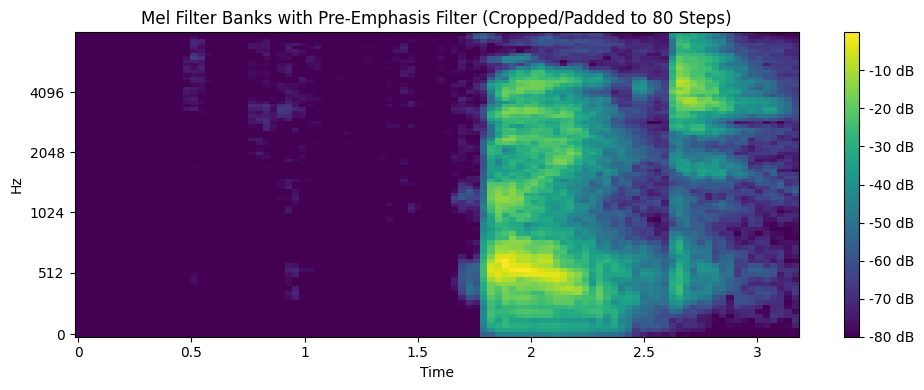

(80, 100)
10


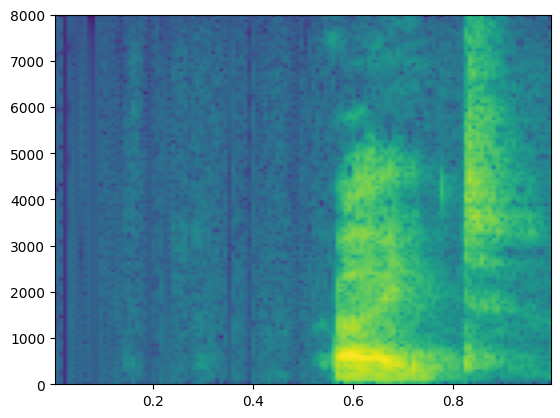

(16000,)


In [14]:
# Visualise the output of the mel encoding
rnd_val = 10#np.random.randint(0, len(test_files))
test_image = test_files[rnd_val]
to_mel_spectrogram(test_image, True)
print(rnd_val)
# Visualise the same input but on soecgram (visual check)
data, samplerate = sf.read(test_image)  
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)
plt.show()
print(data.shape)

In [15]:
# Get all files to loop through

all_files = []

for folder in list(set(folders) - set(exception)):
    files_in_folder = os.listdir(folder)
    for sound_file in files_in_folder:
        all_files.append(folder + "/" + sound_file)

In [ ]:
training_y_data, testing_y_data, validation_y_data = [], [], []
len_training_files = 94824 #len(all_files) - (len(test_files) + len(validation_files))

training_x_data = np.zeros((len_training_files, 80, target_steps),  dtype = np.float32)
testing_x_data = np.zeros((len(test_files), 80, target_steps),  dtype = np.float32)
validation_x_data = np.zeros((len(validation_files), 80, target_steps),  dtype = np.float32)

In [ ]:
validation_count, testing_count, training_count = 0, 0, 0

# save all to a list
for i in trange(len(all_files)):
    
    if all_files[i] in validation_files:
        validation_x_data[validation_count] = (copy.deepcopy(to_mel_spectrogram(all_files[i])))
        validation_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))
        validation_count += 1

    if all_files[i] in test_files:
        testing_x_data[testing_count] = (copy.deepcopy(to_mel_spectrogram(all_files[i])))
        testing_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))
        testing_count += 1
        
    else:
        training_x_data[training_count] = (copy.deepcopy(to_mel_spectrogram(all_files[i])))
        training_y_data.append(int(classes_and_labels[re.split("[/]", all_files[i])[0]]))
        training_count += 1

In [ ]:
print(f"training data size:     {training_count}\t out of {len_training_files}")
print(f"testing data size:      {testing_count}\t out of {len(test_files)}")
print(f"validation data size:   {validation_count}\t out of {len(validation_files)}")

# Save dataset


In [ ]:
os.chdir(directory)

# create new directory for raw HD
assert os.path.isdir("rawSC") == True

os.chdir("rawSC")

In [ ]:
try:
    os.mkdir("rawSC_80input_updated")
except:
    pass
  
os.chdir("rawSC_80input_updated/")
print("current cwd", os.getcwd())

In [ ]:
# data processing
# currently crashing 

# swap axes (maybe need to transpose)
training_x_data = np.swapaxes(training_x_data, 1, 2) 
testing_x_data = np.swapaxes(testing_x_data, 1, 2) 
validation_x_data = np.swapaxes(validation_x_data, 1, 2) 

# move values into positive
training_x_data -= training_x_data.min()
testing_x_data -= testing_x_data.min()
validation_x_data -= validation_x_data.min()

# scale values 
scale_value = 0.0009
training_x_data *= scale_value
testing_x_data = testing_x_data * scale_value
validation_x_data = validation_x_data * scale_value

In [ ]:
np.save("training_x_data.npy", training_x_data)
np.save("training_y_data.npy", training_y_data)
np.save("testing_x_data.npy", testing_x_data)
np.save("testing_y_data.npy", testing_y_data)
np.save("validation_y_data.npy", validation_y_data)
np.save("validation_x_data.npy", validation_x_data)